In [1]:
from scipy.io import wavfile
from scipy import signal
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt
import numpy as np
from scipy import constants

import pandas as pd

In [10]:
def biquad(arr, a0, a1, a2, b0, b1, b2):
    x_prev1 = 0 #x sub n-1
    x_prev2 = 0 #x sub n-2
    
    y_prev1 = 0 #y prev n-1
    y_prev2 = 0 #y sub n-2
    
    output = []
    
    for i in range(len(arr)):
        # i = 0, 1, 2, 3, 4, 5...
            
        x_current = arr[i]
        y_current = (a0 * x_current + a1 * x_prev1 + a2 * x_prev2 - b1 * y_prev1 - b2 * y_prev2) / b0
        
        output.append(y_current)
        
        x_prev2 = x_prev1
        x_prev1 = x_current
        
        y_prev2 = y_prev1
        y_prev1 = y_current
        
    return output

/Users/patrickhultquist/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """Entry point for launching an IPython kernel.


Length of recording: 30.5179375
Length of input data: 1464861


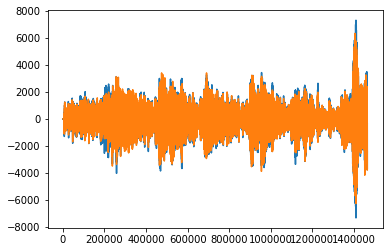

In [20]:
sample_rate, input_data = wavfile.read("./../samples/First30s of Amber Rubarth _ Storms Are On The Ocean - Track 1 -  Dr. Chesky's Binaural Sound Show - 2012.wav")
# plt.plot(input_data[0:100])
# input_data = input_data[18 * 44000:18*44000 + 25]

upsample_scale = 8

cs = CubicSpline(np.arange(len(input_data)), input_data)

xs = np.arange(0, len(input_data), 1/upsample_scale)

# upsampled = np.int16(cs(xs))
upsampled = cs(xs)
upsampled_rate = upsample_scale * sample_rate

print("Length of recording: " + str(len(input_data)/sample_rate))
# plt.plot(xs, cs(xs))
plt.plot(input_data)
print("Length of input data: " + str(len(input_data)))
# plt.plot(xs, upsampled)
# after_biquad = biquad(input_data, 
#        a0 = 0.7368429900740087, 
#        a1 = -1.4736859801480173,
#        a2 = 0.7368429900740087,
#        b0 = 1,
#        b1 = -1.4042736459936045,
#        b2 = 0.5430983143024303
#       )

# plt.plot(after_biquad)

In [21]:
def normalize(original, output_data, normalize_to=None):
    max_original = np.amax(np.absolute(original))
    max_values = np.amax(np.absolute(output_data))
    if normalize_to is not None:
        max_original = normalize_to
    scalar = (max_original / max_values)
    print("Scalar:", scalar)
    
    for i in range(len(output_data)):
        output_data[i] = scalar * output_data[i]

    return np.int16(output_data)

In [22]:
def biquad_with_negative_feedback(arr, a0, a1, a2, b1, b2, fb_k, b0=1, store_servo=True):
    servo_signal_current = 0 #
    
    servo_signal_prev1 = 0 #servo_signal sub n-1
    servo_signal_prev2 = 0 #servo_signal sub n-2
    
    y_prev1 = 0 #y prev n-1
    y_prev2 = 0 #y sub n-2
    
    output = []
    
    for i in range(len(arr)):
        # i = 0, 1, 2, 3, 4, 5...
            
        x_current = arr[i]
        
        servo_signal_current = x_current - fb_k * y_prev1
        
        y_current = (a0 * servo_signal_current + a1 * servo_signal_prev1 + a2 * servo_signal_prev2 - b1 * y_prev1 - b2 * y_prev2) / b0

        if store_servo:
            output.append(servo_signal_current)
        else:
            output.append(y_current)
    
        servo_signal_prev2 = servo_signal_prev1
        servo_signal_prev1 = servo_signal_current
        
        y_prev2 = y_prev1
        y_prev1 = y_current
        
    return output

In [23]:
### 8 inch Dayton DVC ###
# after_resonance_compensation = biquad_with_negative_feedback(
# upsampled,
# a0 = 0.0057426788667661955,
# a1 = 0,
# b0 = 1,
# a2 = -0.0057426788667661955,
# b1 = -1.9884505557207934,
# b2 = 0.9885146422664675,
# fb_k = 0.9
# )

# 127.5hz, Q = 12.6
# 441hz, Q = 16.54
# 775hz, Q = 15.59
# 1366hz, Q = 16.51
# 3,140hz, Q = 9.31
# 13980hz, Q = 7.58


# 127.5hz, Q=12.6
biquad_1 = biquad_with_negative_feedback(
upsampled,
a0 = 0.00008277935170307788,
a1 = 0,
a2 = -0.00008277935170307788,
b1 = -1.9998300893701344,
b2 = 0.9998344412965939,
fb_k = 0.9
)

print("biquad 1 finished")

# 441hz, Q=16.54
biquad_2 = biquad_with_negative_feedback(
biquad_1,
a0 = 0.00021808371710924784,
a1 = 0,
a2 = -0.00021808371710924784,
b1 = -1.9995117757188337,
b2 = 0.9995638325657816,
fb_k = 0.9
)

print("biquad 2 finished")

# 775hz, Q=15.59
biquad_3 = biquad_with_negative_feedback(
biquad_2,
a0 = 0.00040652383054483207,
a1 = 0,
a2 = -0.00040652383054483207,
b1 = -1.999026214440313,
b2 = 0.9991869523389103,
fb_k = 0.9
)

print("biquad 3 finished")

# 1366hz, Q=16.51
biquad_4 = biquad_with_negative_feedback(
biquad_3,
a0 = 0.0006763823480295895,
a1 = 0,
a2 = -0.0006763823480295895,
b1 = -1.9981480213019729,
b2 = 0.9986472353039408,
fb_k = 0.9
)

print("biquad 4 finished")

# 3140hz, Q=9.31
biquad_5 = biquad_with_negative_feedback(
biquad_4,
a0 = 0.0027504981545818886,
a1 = 0,
a2 = -0.0027504981545818886,
b1 = -1.9918671310122849,
b2 = 0.9944990036908364,
fb_k = 0.9
)

print("biquad 5 finished")

# 13980hz, Q=7.58
biquad_6 = biquad_with_negative_feedback(
biquad_5,
a0 = 0.01473718875742926,
a1 = 0,
a2 = -0.01473718875742926,
b1 = -1.9191958688642217,
b2 = 0.9705256224851413,
fb_k = 0.9
)

print("biquad 6 finished")

biquad 1 finished
biquad 2 finished
biquad 3 finished
biquad 4 finished
biquad 5 finished
biquad 6 finished


Downsample Rate: 48000
Length of final file: 30.5179375
Scalar: 1.0689102


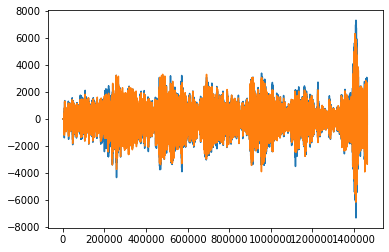

In [24]:
def downsample(item, scale):
    cs = CubicSpline(np.arange(len(item)), item)
    xs = np.arange(0, len(item), 1/ scale)

    downsampled = cs(xs)
    downsampled = np.int16(downsampled)
    downsample_rate = int(downsample_scale * upsampled_rate)
    
    return downsampled, downsample_rate

downsample_scale = 1 / upsample_scale

downsampled_6, downsample_rate = downsample(biquad_6, downsample_scale)
# downsampled_after_resonance_compensation, downsample_after_resonance_compensation_rate = downsample(after_resonance_compensation, downsample_scale)

print("Downsample Rate: "+str(downsample_rate))
print("Length of final file: " + str(len(downsampled_6)/downsample_rate))

wavfile.write("input_data.wav", downsample_rate, input_data)
wavfile.write("biquad_6.wav", downsample_rate, normalize(input_data, downsampled_6))
# wavfile.write("after_resonance_after_backwave.wav", downsample_rate, normalize(input_data, downsampled))
# wavfile.write("after_resonance_compensation.wav", downsample_after_resonance_compensation_rate, normalize(input_data, downsampled_after_resonance_compensation, normalize_to=30000))
plt.plot(downsampled_6)

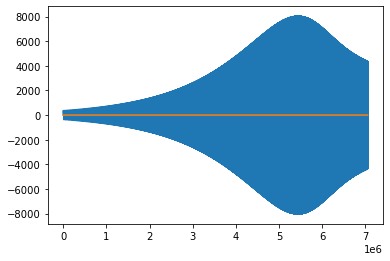

In [87]:
after_resonance_compensation_after_resonance = biquad_with_negative_feedback(
after_resonance_compensation,
a0 = 0.0057426788667661955,
a1 = 0,
b0 = 1,
a2 = -0.0057426788667661955,
b1 = -1.9884505557207934,
b2 = 0.9885146422664675,
fb_k = 0,
store_servo = False
)

plt.plot(after_resonance_compensation_after_resonance)

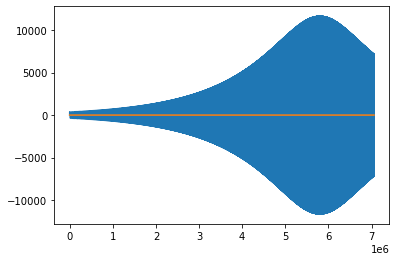

In [88]:
after_resonance_compensation_after_resonance = biquad(
upsampled,
a0 = 0.0057426788667661955,
a1 = 0,
b0 = 1,
a2 = -0.0057426788667661955,
b1 = -1.9884505557207934,
b2 = 0.9885146422664675
)

plt.plot(after_resonance_compensation_after_resonance)